In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.special import binom
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import BII

# 1 Preprocess data

We are using the well known adult dataset.

In [2]:
train = pd.read_csv("../data/adult/adult.data",header=None)
test  = pd.read_csv("../data/adult/adult.test",header=None) 
columns = ["Age", "workclass", "fnlwgt", "education","education-num","marital-status", "occupation"
           ,"relationship", "race","sex","capital-gain","capital-loss", "hours-per-week", "native-country", "label"]
cat_columns = ["workclass", "education", "marital-status", "occupation"
           ,"relationship", "race","sex", "native-country", "label"]
cont_colums = [col for col in columns if col not in cat_columns]
train.columns, test.columns = columns, columns
#Dropping fnlwgt as it's not an actual feature but a weighting factor
train.drop("fnlwgt", axis=1, inplace=True)
test.drop("fnlwgt", axis=1, inplace=True)
columns.remove("fnlwgt")
cont_colums.remove("fnlwgt")

We encode the categorical variables

In [3]:
encoders = {}
train_transformed, test_transformed = pd.DataFrame(), pd.DataFrame()
for category in cat_columns:
    if category == "label":
        train_transformed[category] = train[category]
        test_transformed[category] = test[category]
        continue
    if category == "education":
        continue;
    encoder = OneHotEncoder()
    encoder.fit(np.asarray(train[category]).reshape(-1, 1))
    encoders[category] = encoder
    transformed_featue_train = pd.get_dummies(train[category],prefix=category)
    transformed_featue_test = pd.get_dummies(test[category],prefix=category)
    for column in transformed_featue_train.columns:
        train_transformed[column] = transformed_featue_train[column]
        try:
            test_transformed[column] = transformed_featue_test[column]
        except :
            test_transformed[column] = np.zeros(len(test_transformed))
for category in cont_colums:
    train_transformed[category] = train[category]
    test_transformed[category] = test[category]
# We treat education slightly differently as it is already encoded in "education-num", so we just use this encoding
#(it is ordered with respect to the level of education, while LabelEncoders are lexicographic) 
# The right way would be to drop the column but we leave it to show some axiomatic properties
train_transformed["education"] = train_transformed["education-num"]
test_transformed["education"] = test_transformed["education-num"]
cont_colums.append("education")
cat_columns.remove("education")

In [4]:
x_train, y_train = train_transformed.loc[:, train_transformed.columns != 'label'], train_transformed["label"]
x_test,  y_test  = test_transformed.loc[:, test_transformed.columns != 'label'], test_transformed["label"]
cat_columns.remove("label")
columns = [col for col in columns if col != "label"]
reordered_test = test[cont_colums + cat_columns]

# 2 Train baseline classifier (Figure 1)

We train a simple decision tree that allows us to see how the explanations work on a real dataset

In [5]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf = clf.fit(x_train, y_train)

In [6]:
clf.score(x_train, y_train), clf.score(x_test,  y_test)

(0.8438930008292128, 0.8447884036607088)

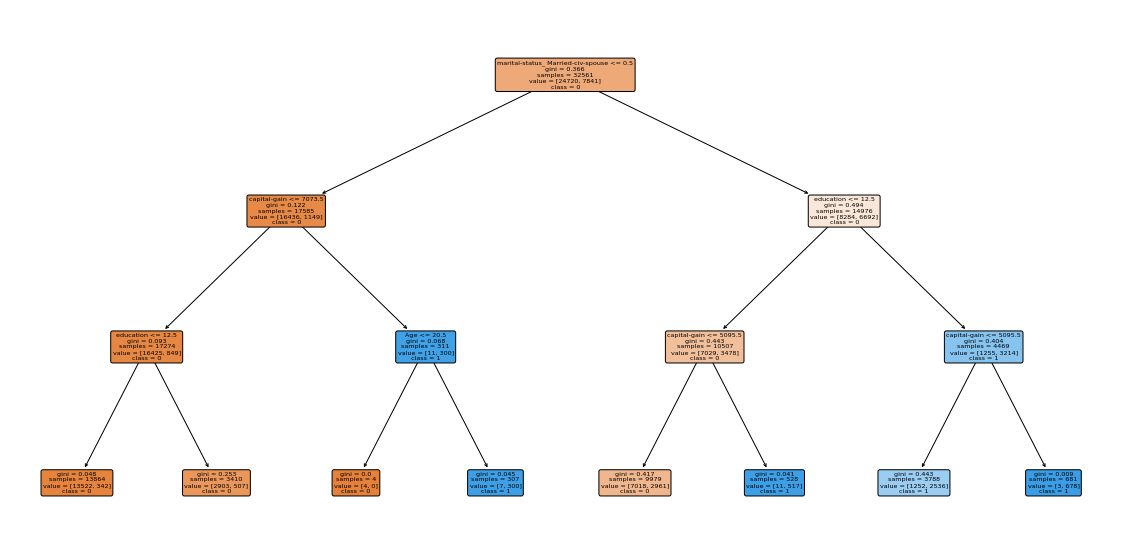

In [7]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf,feature_names=x_train.columns
               , class_names=[str(0),str(1)], filled=True, rounded=True);

In [8]:
# Categorical variables in the baseline are set to 0 and continues to the median
baseline = pd.DataFrame(data=np.zeros([1,len(x_train.columns)]),columns= x_train.columns)
for category in cont_colums:
    baseline[category] = np.median(x_train[category])

In [9]:
baseline

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,Age,education-num,capital-gain,capital-loss,hours-per-week,education
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,37.0,10.0,0.0,0.0,40.0,10.0


In [10]:
b_clf = BII.BanzhafModel(clf, np.asarray(baseline))

In [11]:
# We select the points specified in the paper
points_of_interest = np.where((test["marital-status"] == " Married-civ-spouse") & (test["capital-gain"] > 5095) & (test["capital-gain"] < 7073))[0]
points_of_interest = points_of_interest[:10]

In [12]:
test.iloc[points_of_interest]

,Age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
10,65,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,>50K
58,42,Self-emp-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,50,United-States,>50K
92,33,Private,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,5178,0,10,United-States,>50K
347,59,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,50,United-States,>50K
537,44,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,40,United-States,>50K
781,62,?,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,5178,0,40,United-States,>50K
887,36,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,5178,0,40,United-States,>50K
1330,29,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,5178,0,45,United-States,>50K
1829,47,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,40,United-States,>50K
1945,36,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,5178,0,50,United-States,>50K


In [13]:
onehot_columns = x_train.columns.to_list()

## Linear Explanations

In [14]:
number_samples = 10000

In [15]:
%%time
n_features = len(cont_colums) + len(cat_columns)
linear_banzhaf_values = np.zeros([x_test.shape[0],n_features])
linear_shap_values = np.zeros([x_test.shape[0],n_features])
linear_qii_values = np.zeros([x_test.shape[0],n_features])
for i in points_of_interest:
    print(i, end=", ")
    test_point = np.asarray(x_test.iloc[i:i+1,:])
    linear_banzhaf_values[i] = BII.one_hot_banzhaf(test_point,b_clf,
                                                   cont_colums,cat_columns,
                                                   onehot_columns, number_samples=number_samples)
    linear_shap_values[i] = BII.one_hot_shapley(test_point,b_clf,
                                            cont_colums,cat_columns,
                                            onehot_columns, number_samples=number_samples)
    linear_qii_values[i] = BII.one_hot_qii(test_point,b_clf,
                                                     cont_colums,cat_columns,
                                                     onehot_columns)

10, 58, 92, 347, 537, 781, 887, 1330, 1829, 1945, CPU times: user 4.67 s, sys: 21.9 ms, total: 4.69 s
Wall time: 4.67 s


## Binary explanations (Interactions)

In [16]:
%%time
n_features = len(cont_colums) + len(cat_columns)
bin_banzhaf_values = np.zeros([x_test.shape[0],n_features,n_features])
bin_shap_values = np.zeros([x_test.shape[0],n_features,n_features])
bin_qii_values = np.zeros([x_test.shape[0],n_features,n_features])
for i in points_of_interest:
    print(i, end=", ")
    test_point = np.asarray(x_test.iloc[i:i+1,:])
    bin_banzhaf_values[i] = BII.one_hot_binary_banzhaf(test_point,b_clf,cont_colums,
                                                              cat_columns,onehot_columns,
                                                              number_samples=number_samples)
    bin_shap_values[i] =  BII.one_hot_binary_shapley(test_point,b_clf,cont_colums,
                                                            cat_columns,onehot_columns,
                                                            number_samples=number_samples)
    bin_qii_values[i] =  BII.one_hot_binary_qii(test_point,b_clf,cont_colums,
                                                               cat_columns,onehot_columns)

10, 58, 92, 347, 537, 781, 887, 1330, 1829, 1945, CPU times: user 53.9 s, sys: 33.2 ms, total: 53.9 s
Wall time: 53.9 s


## Monotonicity

In [17]:
import copy
# We create a copy of the original tree and change it to test the monotonicity axiom
clf_mon = copy.deepcopy(clf)
shift = -2157
for j in [0,8,12,13]:
    clf_mon.tree_.value[j][0][0] = clf_mon.tree_.value[j][0][0] -shift
    clf_mon.tree_.value[j][0][1] = clf_mon.tree_.value[j][0][1] +shift

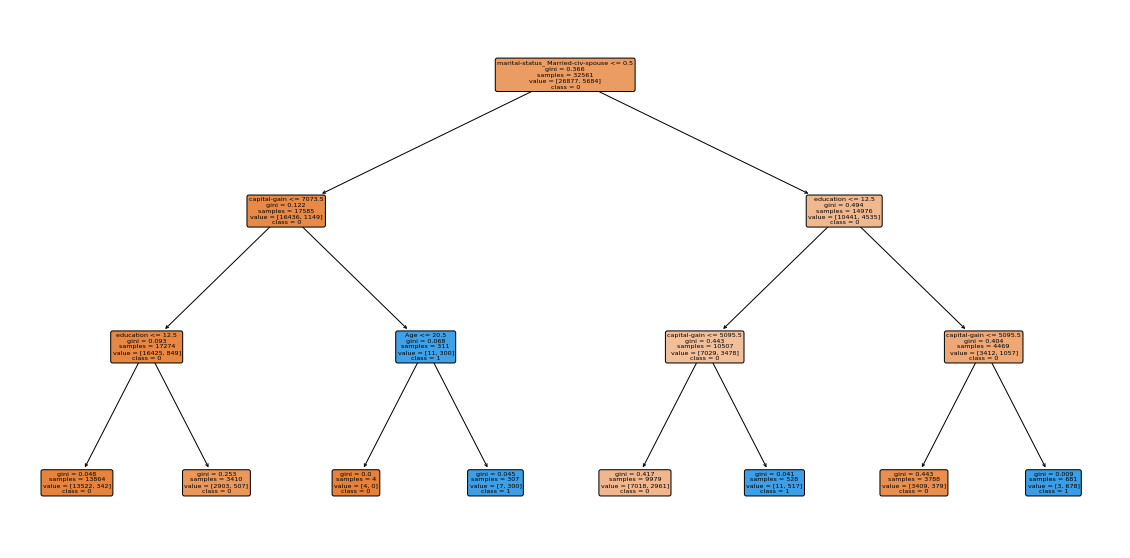

In [18]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf_mon,feature_names=x_train.columns
               , class_names=[str(0),str(1)], filled=True, rounded=True);

In [19]:
b_clf_mon = BII.BanzhafModel(clf_mon, np.asarray(baseline))

In [ ]:
%%time
n_features = len(cont_colums) + len(cat_columns)
mon_bin_banzhaf_values = np.zeros([x_test.shape[0],n_features,n_features])
mon_bin_shap_values = np.zeros([x_test.shape[0],n_features,n_features])
mon_bin_qii_values = np.zeros([x_test.shape[0],n_features,n_features])
mon_linear_banzhaf_values = np.zeros([x_test.shape[0],n_features])
mon_linear_shap_values = np.zeros([x_test.shape[0],n_features])
mon_linear_qii_values = np.zeros([x_test.shape[0],n_features])
for i in points_of_interest:
    print(i, end=", ")
    test_point = np.asarray(x_test.iloc[i:i+1,:])
    mon_bin_banzhaf_values[i] = BII.one_hot_binary_banzhaf(test_point,b_clf_mon,cont_colums,
                                                              cat_columns,onehot_columns,
                                                              number_samples=number_samples)
    mon_bin_shap_values[i] =  BII.one_hot_binary_shapley(test_point,b_clf_mon,cont_colums,
                                                            cat_columns,onehot_columns,
                                                            number_samples=number_samples)
    mon_bin_qii_values[i] =  BII.one_hot_binary_qii(test_point,b_clf_mon,cont_colums,
                                                               cat_columns,onehot_columns)
    mon_linear_banzhaf_values[i] = BII.one_hot_banzhaf(test_point,b_clf_mon,
                                                   cont_colums,cat_columns,
                                                   onehot_columns, number_samples=number_samples)
    mon_linear_shap_values[i] = BII.one_hot_shapley(test_point,b_clf_mon,
                                            cont_colums,cat_columns,
                                            onehot_columns, number_samples=number_samples)
    mon_linear_qii_values[i] = BII.one_hot_qii(test_point,b_clf_mon,
                                                     cont_colums,cat_columns,
                                                     onehot_columns)

10, 

In [ ]:
def add_diagaonal_to_binary(binary_values,linear_values):
    for sample_number,sample in enumerate(linear_values):
        for i,feature in enumerate(sample):
            binary_values[sample_number,i,i] = feature
    return binary_values

In [ ]:
def extend_linear_values_with_diagonal(linear_values):
    extension = np.zeros([linear_values.shape[0],linear_values.shape[1],linear_values.shape[1]])
    for sample_number,sample in enumerate(linear_values):
        for i,feature_1 in enumerate(sample):
            extension[sample_number,i,i] = feature_1
            for j, feature_2 in enumerate(sample[i+1:]):
                extension[sample_number,i,i+1+j] = feature_1 + feature_2
    return extension

In [ ]:
value = {}
number = 2
value["lin_ban"] = add_diagaonal_to_binary(np.zeros_like(bin_banzhaf_values[points_of_interest][number][None]),linear_banzhaf_values[points_of_interest][number][None])[0]
value["lin_sha"] = add_diagaonal_to_binary(np.zeros_like(bin_shap_values[points_of_interest][number][None]),linear_shap_values[points_of_interest][number][None])[0]
value["lin_qii"] = add_diagaonal_to_binary(np.zeros_like(bin_qii_values[points_of_interest][number][None]),linear_qii_values[points_of_interest][number][None])[0]

value["ext_ban"] = extend_linear_values_with_diagonal(linear_banzhaf_values[points_of_interest][number][None])[0]
value["ext_sha"] = extend_linear_values_with_diagonal(linear_shap_values[points_of_interest][number][None])[0]
value["ext_qii"] = extend_linear_values_with_diagonal(linear_qii_values[points_of_interest][number][None])[0]


value["bin_ban"] = add_diagaonal_to_binary(bin_banzhaf_values[points_of_interest][number][None],linear_banzhaf_values[points_of_interest][number][None])[0]
value["bin_sha"] = add_diagaonal_to_binary(bin_shap_values[points_of_interest][number][None],linear_shap_values[points_of_interest][number][None])[0]
value["bin_qii"] = add_diagaonal_to_binary(bin_qii_values[points_of_interest][number][None],linear_qii_values[points_of_interest][number][None])[0]

value["mon_ban"] = add_diagaonal_to_binary(mon_bin_banzhaf_values[points_of_interest][number][None],mon_linear_banzhaf_values[points_of_interest][number][None])[0]
value["mon_sha"] = add_diagaonal_to_binary(mon_bin_shap_values[points_of_interest][number][None],mon_linear_shap_values[points_of_interest][number][None])[0]
value["mon_qii"] = add_diagaonal_to_binary(mon_bin_qii_values[points_of_interest][number][None],mon_linear_qii_values[points_of_interest][number][None])[0]

In [ ]:
lim = np.asarray([0, 0, 0.67, 0, 0, 0.20, 0, 0.31, 0, 0, 0, 0, 0,])
value["lin_lim"] = add_diagaonal_to_binary(np.zeros_like(bin_banzhaf_values[points_of_interest][number][None]),lim[None])[0]
value["ext_lim"] = extend_linear_values_with_diagonal(lim[None])[0]
value["bin_lim"] = np.zeros_like(value["ext_lim"])
value["mon_lim"] = np.zeros_like(value["ext_lim"])

In [ ]:
approach_types = ["ext","bin","mon"]
method_types = ["ban","sha","qii", "lim"]
col_labels = reordered_test.columns
small_col_labels = ["capital-gain", "education", "marital-status"]
col_ind = [i for i,label in enumerate(col_labels) if label in small_col_labels]

In [ ]:
# Rescaling
max_values = {}
for method_type in method_types:
    max_values[method_type] = 0
    for approach_type in approach_types:
        harvest = value["{}_{}".format(approach_type,method_type)][col_ind][:,col_ind]
        if max_values[method_type] < np.max(np.abs(harvest)):
            max_values[method_type] = np.max(np.abs(harvest))

In [ ]:
test.iloc[points_of_interest[number:number+1]]

In [ ]:
fig, axs = plt.subplots(4,3,figsize=(20,20))
for i_ind, approach_type in enumerate(approach_types):
    for j_ind, method_type in enumerate(method_types):
        # We want to show all ticks...
        ax = axs[j_ind][i_ind]
        harvest = value["{}_{}".format(approach_type,method_type)][col_ind][:,col_ind]/max_values[method_type]
        ax.set_xticks(np.arange(len(small_col_labels)))
        ax.set_yticks(np.arange(len(small_col_labels)))
        # ... and label them with the respective list entries
        ax.set_xticklabels(small_col_labels)
        ax.set_yticklabels(small_col_labels)
        
        ax.imshow(harvest,vmin=-1,vmax=1,cmap="RdBu")
        ax.set_title("{}_{}".format(approach_type,method_type))
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(len(small_col_labels)):
            for j in range(len(small_col_labels)):
                text = ax.text(j, i, "{:.2f}".format(harvest[i, j]),
                               ha="center", va="center", color="k")

        fig.tight_layout()
plt.show()

## Helper functions for plotting in latex

In [ ]:
for j_ind, method_type in enumerate(method_types):
    for i_ind, approach_type in enumerate(approach_types):
        # We want to show all ticks...
        ax = axs[j_ind][i_ind]
        harvest = value["{}_{}".format(approach_type,method_type)][col_ind][:,col_ind]/max_values[method_type]
        print("%{}_{}".format(approach_type,method_type))
        print("\\begin{tikzpicture}")
        print("\def\\values{{")
        for row in harvest:
            print("{", end="")
            for entry in row:
                print("{:.2f}".format(entry),end=", ")
            print("},")
        print("}}")
        print("\Heatmap")
        print("\end{tikzpicture}")
        print("&")
    print("")